In [1]:
using RCall
using DataFrames, DataFramesMeta
using CSV
using DataVoyager
ENV["LINES"] = 10
ENV["COLUMNS"]=10000;

### Load Covid Data

source: https://covid.ourworldindata.org/data/owid-covid-data.csv

In [2]:
df = CSV.read("owid-covid-data-latest.csv",DataFrame)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
,String,String?,String,Date,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,missing,missing,missing,missing,0.126,0.126,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,8.33,3.98354e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.511,missing,missing,missing,missing
2,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,missing,missing,missing,missing,0.126,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,8.33,3.98354e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.511,missing,missing,missing,missing
3,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,missing,missing,missing,missing,0.126,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,8.33,3.98354e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.511,missing,missing,missing,missing
4,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,missing,missing,missing,missing,0.126,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,8.33,3.98354e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.511,missing,missing,missin

### Check Data Summary

In [3]:
R"summary($df)"

RObject{StrSxp}
   iso_code          continent           location              date           
 Length:163787      Length:163787      Length:163787      Min.   :2020-01-01  
 Class :character   Class :character   Class :character   1st Qu.:2020-09-05  
 Mode  :character   Mode  :character   Mode  :character   Median :2021-03-09  
                                                          Mean   :2021-03-03  
                                                          3rd Qu.:2021-08-31  
                                                          Max.   :2022-02-22  
                                                                              
  total_cases          new_cases       new_cases_smoothed  total_deaths    
 Min.   :        1   Min.   : -74347   Min.   :  -6223    Min.   :      1  
 1st Qu.:     1921   1st Qu.:      1   1st Qu.:      7    1st Qu.:     77  
 Median :    25155   Median :     78   Median :    105    Median :    765  
 Mean   :  2448211   Mean   :  11271   Mean   : 

In [4]:
ENV["LINES"] = 10
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,Type
1,iso_code,,ABW,,ZWE,0,String
2,continent,,Africa,,South America,9813,"Union{Missing, String}"
3,location,,Afghanistan,,Zimbabwe,0,String
4,date,,2020-01-01,2021-03-09,2022-02-22,0,Date
5,total_cases,2.44821e6,1.0,25155.0,4.27816e8,3005,"Union{Missing, Float64}"
6,new_cases,11270.7,-74347.0,78.0,4.23502e6,3035,"Union{Missing, Float64}"
7,new_cases_smoothed,11220.2,-6223.0,104.714,3.43888e6,4186,"Union{Missing, Float64}"
8,total_deaths,56716.2,1.0,765.0,5.90594e6,20746,"Union{Missing, Float64}"
9,new_deaths,171.198,-3933.0,2.0,18057.0,20567,"Union{Missing, Float64}"


### Column Subset: Remove redundant columns

In [5]:
features = [:continent,:location,:date,:new_cases,:new_deaths,:population, :population_density]
dfa = df[:,features]
dfn = @chain dfa begin
    @subset(:new_cases .>= 0)
    @subset(:new_deaths .>= 0)
end
describe(dfn)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,Type
1,continent,,Africa,,South America,9790,"Union{Missing, String}"
2,location,,Afghanistan,,Zimbabwe,0,String
3,date,,2020-01-22,2021-03-22,2022-02-22,0,Date
4,new_cases,12655.9,0.0,144.0,4.23502e6,0,"Union{Missing, Float64}"
5,new_deaths,171.546,0.0,2.0,18057.0,0,"Union{Missing, Float64}"
6,population,1.67108e8,4981.0,1.01602e7,7.87497e9,734,"Union{Missing, Float64}"
7,population_density,365.549,0.137,83.479,19347.5,12816,"Union{Missing, Float64}"


### Row Subset: Filter  Asia

In [6]:
dfasia = R"""
          options(warn=-1)
          library(tidyverse)
          $dfn %>% filter(continent == "Asia") %>% 
          filter(new_cases >= 0) %>% filter(new_deaths >= 0)
        """ |> rcopy

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
│ ✔ tibble  3.0.4     ✔ dplyr   1.0.2
│ ✔ tidyr   1.1.2     ✔ stringr 1.4.0
│ ✔ readr   1.4.0     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /Users/ppalmes/.julia/packages/RCall/6kphM/src/io.jl:172


,continent,location,date,new_cases,new_deaths,population,population_density
,String,String,Date,Float64,Float64,Float64,Float64?
1,Asia,Afghanistan,2020-03-23,6.0,1.0,3.98354e7,54.422
2,Asia,Afghanistan,2020-03-24,2.0,0.0,3.98354e7,54.422
3,Asia,Afghanistan,2020-03-25,32.0,0.0,3.98354e7,54.422
4,Asia,Afghanistan,2020-03-26,6.0,1.0,3.98354e7,54.422
5,Asia,Afghanistan,2020-03-27,11.0,0.0,3.98354e7,54.422
6,Asia,Afghanistan,2020-03-28,15.0,0.0,3.98354e7,54.422
7,Asia,Afghanistan,2020-03-29,8.0,2.0,3.98354e7,54.422
8,Asia,Afghanistan,2020-03-30,0.0,0.0,3.98354e7,54.422
9,Asia,Afghanistan,2020-03-31,52.0,0.0,3.98354e7,54.422


In [7]:
dfasia=@subset(dfn, :continent .== "Asia")

,continent,location,date,new_cases,new_deaths,population,population_density
,String?,String,Date,Float64?,Float64?,Float64?,Float64?
1,Asia,Afghanistan,2020-03-23,6.0,1.0,3.98354e7,54.422
2,Asia,Afghanistan,2020-03-24,2.0,0.0,3.98354e7,54.422
3,Asia,Afghanistan,2020-03-25,32.0,0.0,3.98354e7,54.422
4,Asia,Afghanistan,2020-03-26,6.0,1.0,3.98354e7,54.422
5,Asia,Afghanistan,2020-03-27,11.0,0.0,3.98354e7,54.422
6,Asia,Afghanistan,2020-03-28,15.0,0.0,3.98354e7,54.422
7,Asia,Afghanistan,2020-03-29,8.0,2.0,3.98354e7,54.422
8,Asia,Afghanistan,2020-03-30,0.0,0.0,3.98354e7,54.422
9,Asia,Afghanistan,2020-03-31,52.0,0.0,3.98354e7,54.422


### Visualize Asia Covid Trend

In [8]:
# dfasia |> Voyager()

### Zoom-in to Philippines

In [9]:
dfph=R"$dfasia %>% filter(location=='Philippines')" |> rcopy

,continent,location,date,new_cases,new_deaths,population,population_density
,String,String,Date,Float64,Float64,Float64,Float64
1,Asia,Philippines,2020-02-02,1.0,1.0,1.11047e8,351.873
2,Asia,Philippines,2020-02-03,0.0,0.0,1.11047e8,351.873
3,Asia,Philippines,2020-02-04,0.0,0.0,1.11047e8,351.873
4,Asia,Philippines,2020-02-05,0.0,0.0,1.11047e8,351.873
5,Asia,Philippines,2020-02-06,0.0,0.0,1.11047e8,351.873
6,Asia,Philippines,2020-02-07,1.0,0.0,1.11047e8,351.873
7,Asia,Philippines,2020-02-08,0.0,0.0,1.11047e8,351.873
8,Asia,Philippines,2020-02-09,0.0,0.0,1.11047e8,351.873
9,Asia,Philippines,2020-02-10,0.0,0.0,1.11047e8,351.873


In [10]:
# dfph |> Voyager()

In [11]:
dfcases = R"$dfasia %>% select(location,date,new_cases,new_deaths)" |> rcopy

,location,date,new_cases,new_deaths
,String,Date,Float64,Float64
1,Afghanistan,2020-03-23,6.0,1.0
2,Afghanistan,2020-03-24,2.0,0.0
3,Afghanistan,2020-03-25,32.0,0.0
4,Afghanistan,2020-03-26,6.0,1.0
5,Afghanistan,2020-03-27,11.0,0.0
6,Afghanistan,2020-03-28,15.0,0.0
7,Afghanistan,2020-03-29,8.0,2.0
8,Afghanistan,2020-03-30,0.0,0.0
9,Afghanistan,2020-03-31,52.0,0.0


### All Asia

In [12]:
# dfcases |> Voyager()

### Plot interesting trends from the visualization

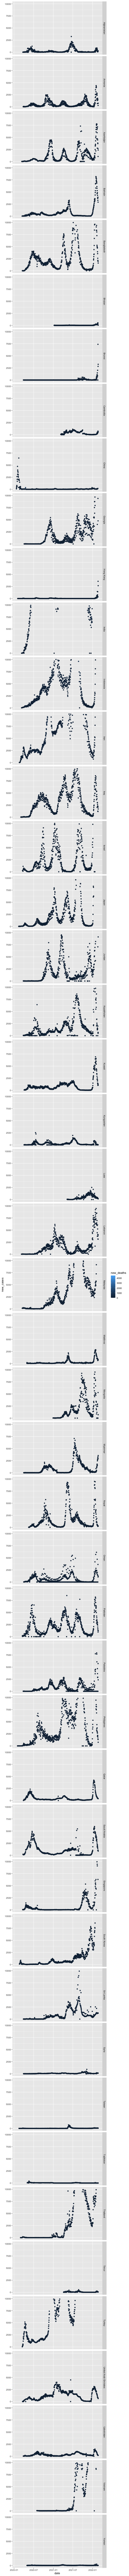

RObject{VecSxp}


In [13]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 500, :height => 10000))
R"""
options(warn=-1)
library(ggplot2)

ggplot($dfcases,aes(date,new_cases))+
  geom_point(aes(color=new_deaths))+ylim(0,10000)+
  facet_grid(location ~ .)
"""

In [14]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 700, :height => 300))

function plotdeaths(df::DataFrame,ctry::String)
  R"""
     options(warn=-1)
     library(ggplot2)
     ctr = $df %>% filter(location == $ctry)
     ggplot(ctr,aes(date,new_deaths))+
        geom_point(aes(color=new_deaths))+
        scale_x_date(date_breaks = "1 month", date_labels =  "%b %Y")+
        theme(axis.text.x=element_text(angle=60, hjust=1))
  """
end

function plotcases(df::DataFrame,ctry::String)
  R"""
     options(warn=-1)
     library(ggplot2)
     ctr = $df %>% filter(location == $ctry)
     ggplot(ctr,aes(date,new_cases))+
        geom_point(aes(color=new_cases))+
        scale_x_date(date_breaks = "1 month", date_labels =  "%b %Y")+
        theme(axis.text.x=element_text(angle=60, hjust=1))
  """
end
function covidplot(df,ctry)
    display(plotcases(df,ctry));
    display(plotdeaths(df,ctry));
end

covidplot (generic function with 1 method)

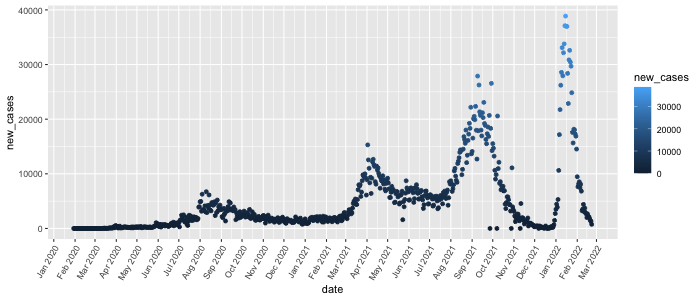

RObject{VecSxp}


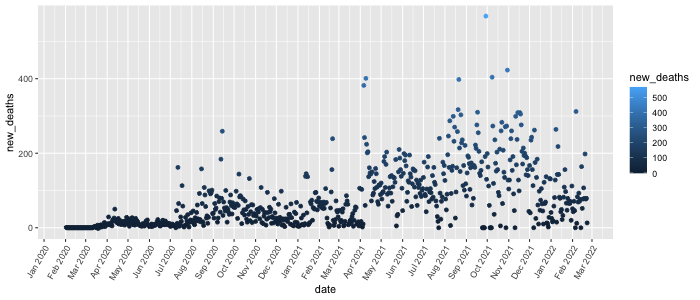

RObject{VecSxp}


In [15]:
covidplot(df,"Philippines")

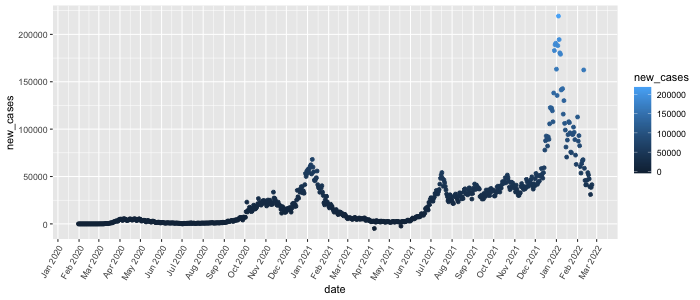

RObject{VecSxp}


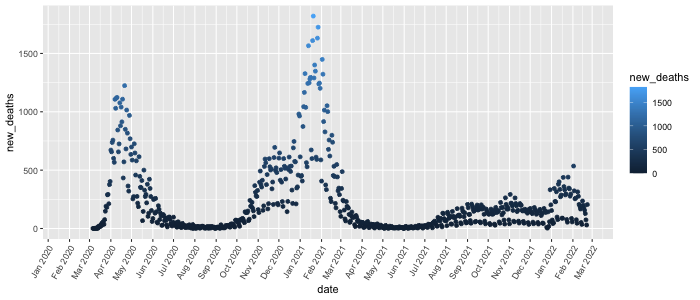

RObject{VecSxp}


In [16]:
covidplot(df,"United Kingdom")

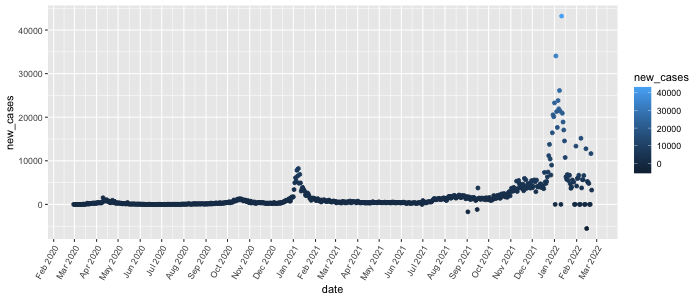

RObject{VecSxp}


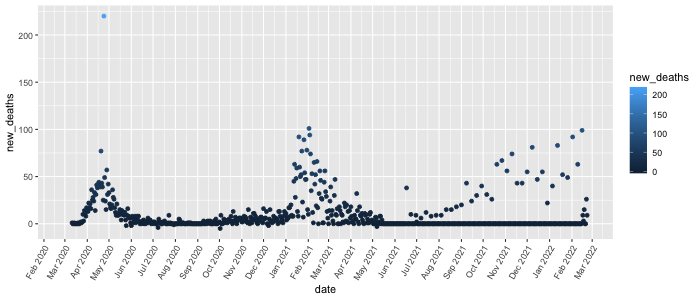

RObject{VecSxp}


In [17]:
covidplot(df,"Ireland")

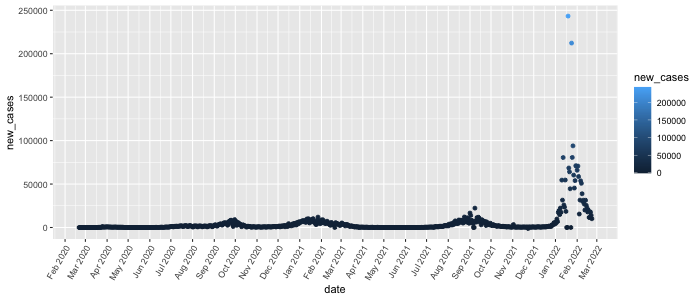

RObject{VecSxp}


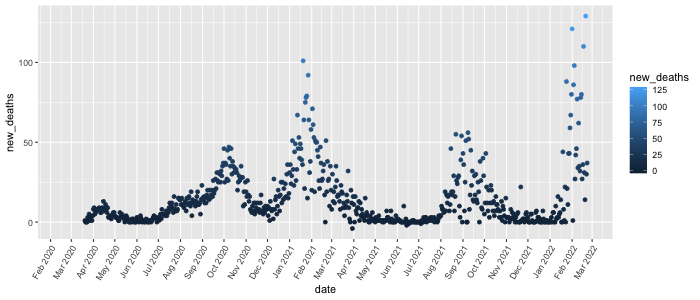

RObject{VecSxp}


In [18]:
covidplot(df,"Israel")

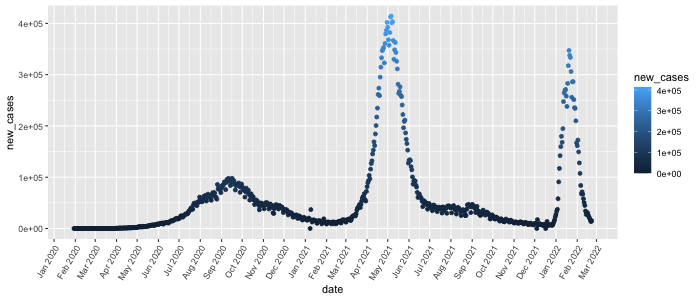

RObject{VecSxp}


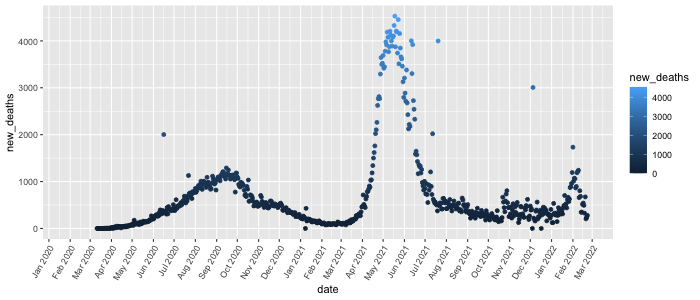

RObject{VecSxp}


In [19]:
covidplot(df,"India")

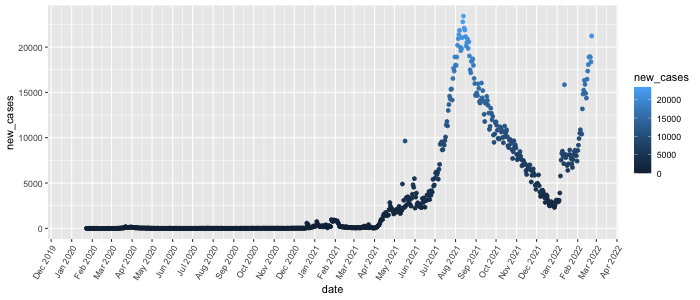

RObject{VecSxp}


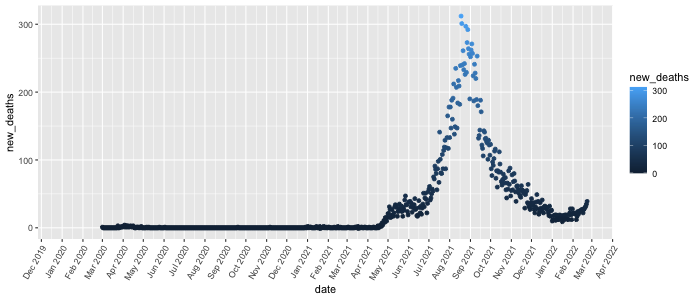

RObject{VecSxp}


In [20]:
covidplot(df,"Thailand")

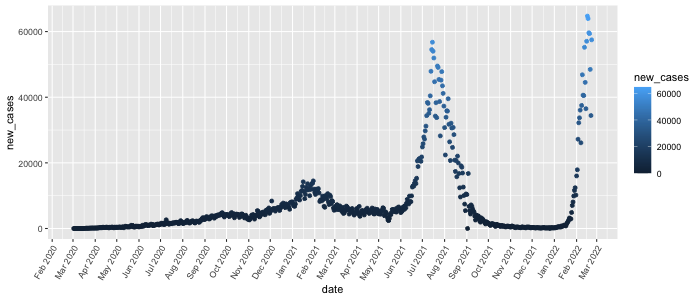

RObject{VecSxp}


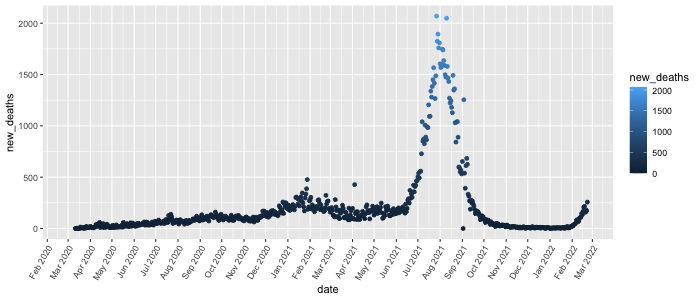

RObject{VecSxp}


In [21]:
covidplot(df,"Indonesia")

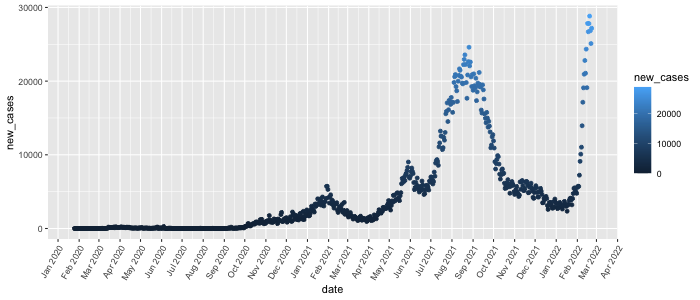

RObject{VecSxp}


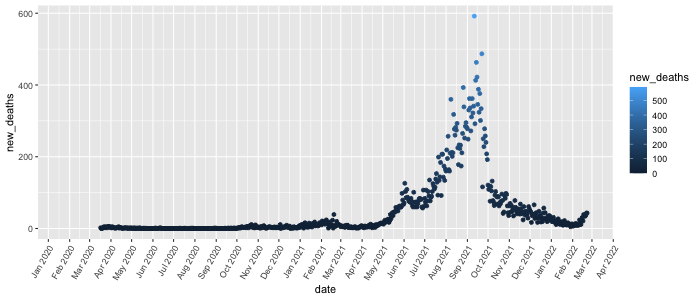

RObject{VecSxp}


In [22]:
covidplot(df,"Malaysia")

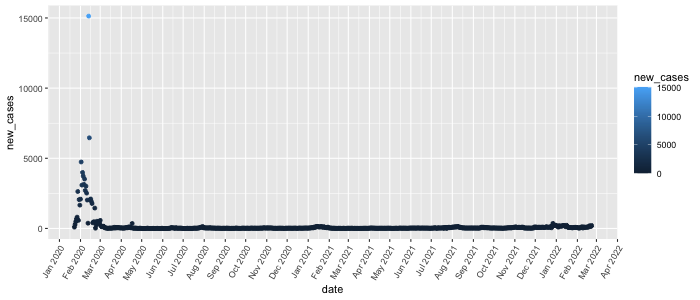

RObject{VecSxp}


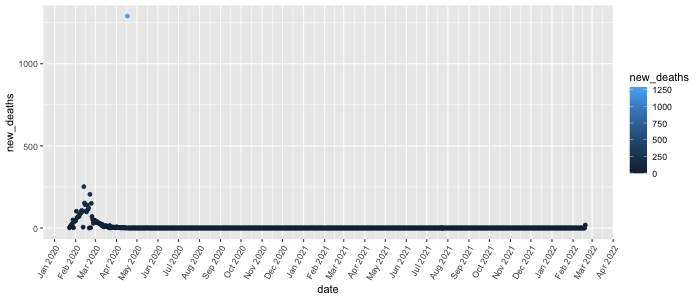

RObject{VecSxp}


In [23]:
covidplot(df,"China")

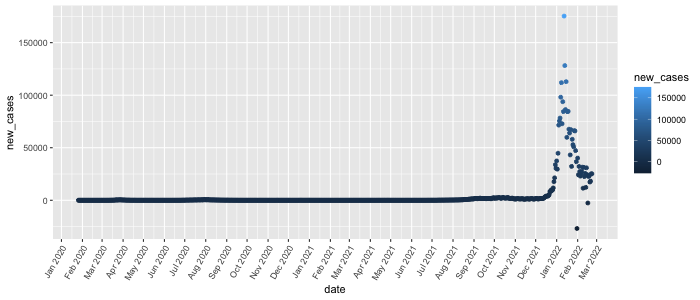

RObject{VecSxp}


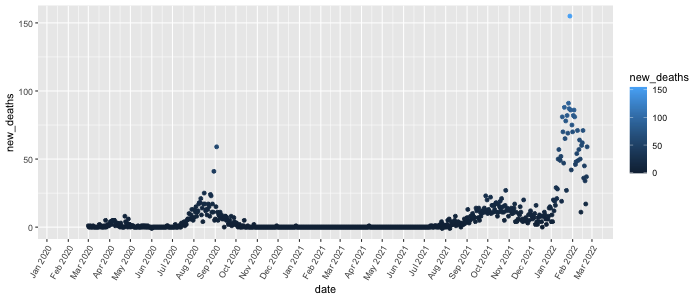

RObject{VecSxp}


In [24]:
covidplot(df,"Australia")

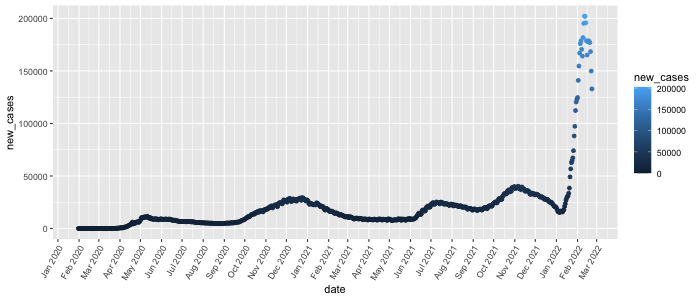

RObject{VecSxp}


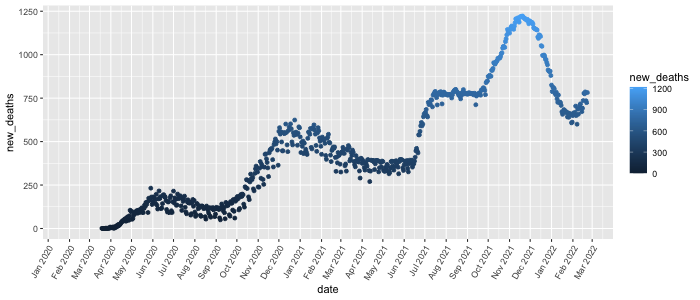

RObject{VecSxp}


In [25]:
covidplot(df,"Russia")

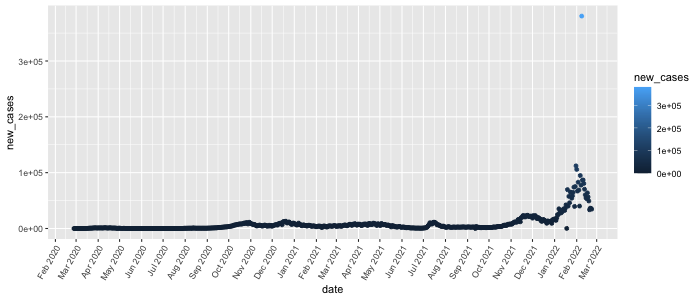

RObject{VecSxp}


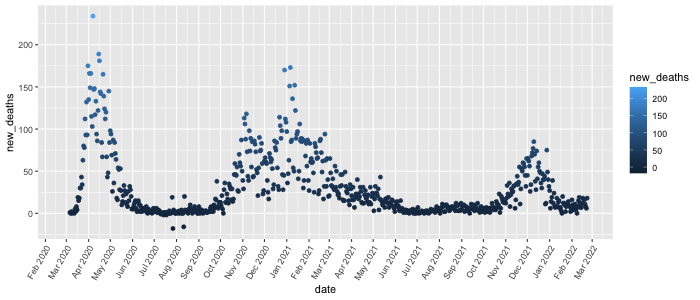

RObject{VecSxp}


In [26]:
covidplot(df,"Netherlands")

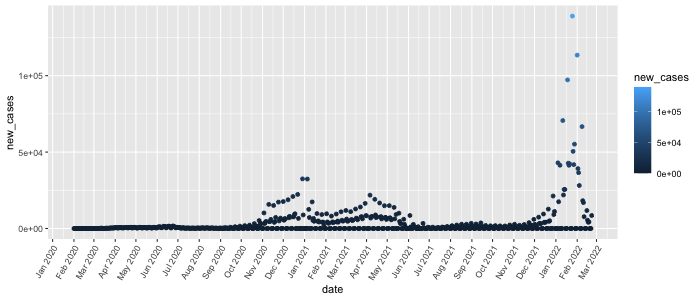

RObject{VecSxp}


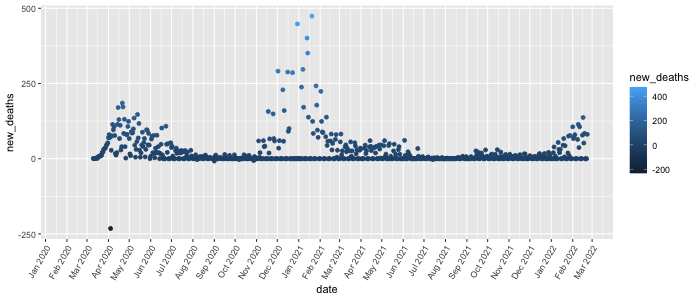

RObject{VecSxp}


In [27]:
covidplot(df,"Sweden")

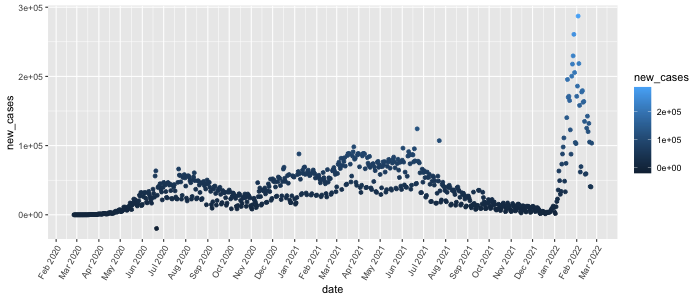

RObject{VecSxp}


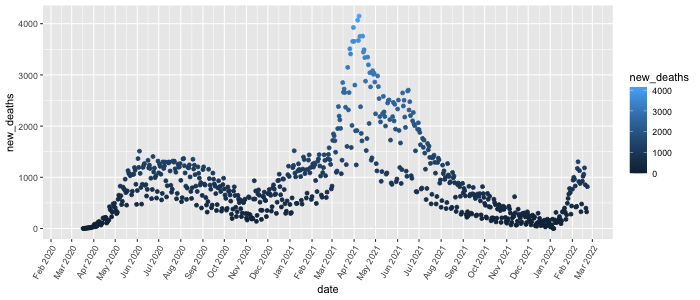

RObject{VecSxp}


In [28]:
covidplot(df,"Brazil")

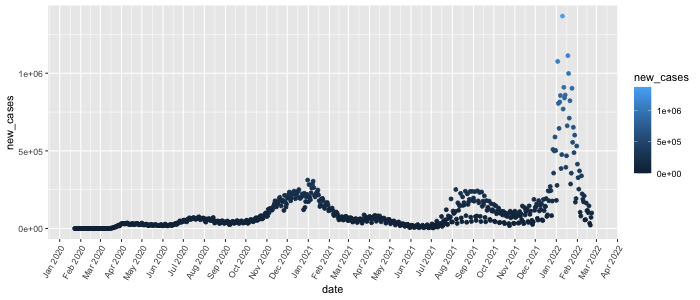

RObject{VecSxp}


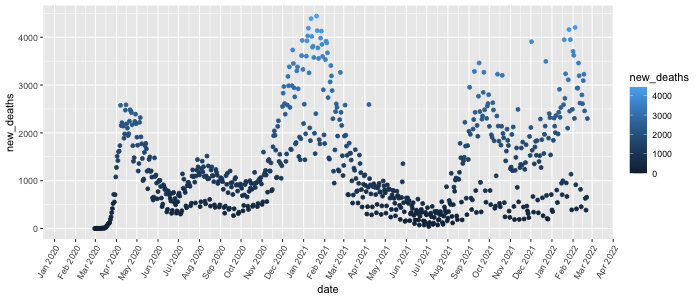

RObject{VecSxp}


In [29]:
covidplot(df,"United States")

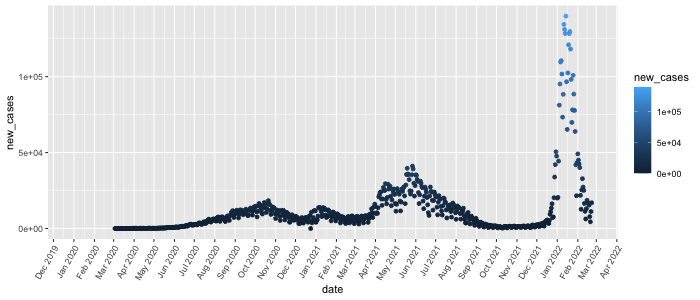

RObject{VecSxp}


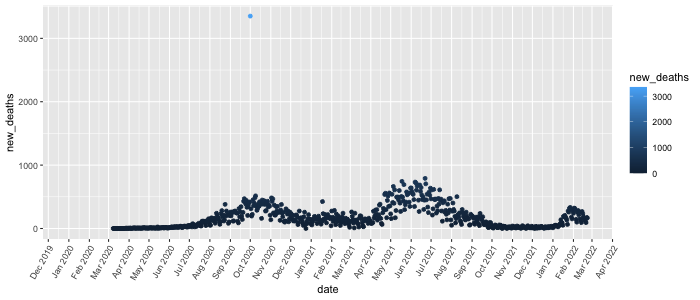

RObject{VecSxp}


In [30]:
covidplot(df,"Argentina")